In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#descargar dataset
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains #averiguar subset 

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [3]:
#Nos vamos a centrar en el subset de electronicos
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

Dataset subjqa downloaded and prepared to /root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
print(subjqa["train"]["answers"][1]) #nested dictionary

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [5]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


Las columnas más interesantes del dataset:
* title: The Amazon Standard Identification Number (ASIN) associated with each product
* question
* answer.answer_text: span of text in the review labeled by the annotator
* answer.answer_start: The start character index of the answer span
* context: customer review

In [6]:
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7) #para hacer una muestra random
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [7]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

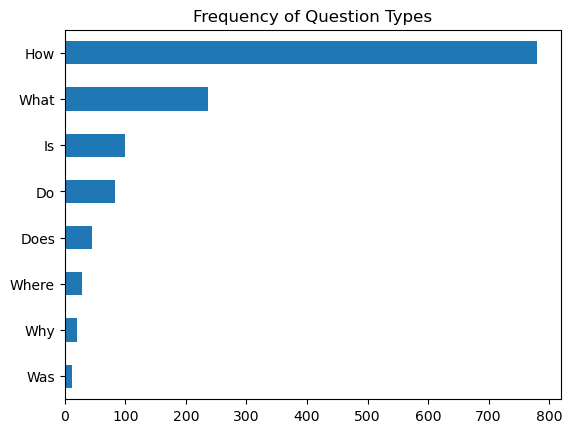

In [8]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

import matplotlib.pyplot as plt

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [9]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


**Frame the supervised learning problem.**

Span classification

**Tokenize and encode text for QA tasks.**

In [10]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [11]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")
inputs
# token_type_ids= 0 question token 1 context token

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [12]:
print(tokenizer.decode(inputs["input_ids"][0]))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [13]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [14]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [15]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [16]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits)+1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [17]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/opt/conda/lib/python3.7/site-packages/transformers/pipelines/question_answering.py:323: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651616334915161, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082962095737457,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253521054983139,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [18]:
pipe(question="Why is there no data?", context=context,
     handle_impossible_answer=True)

{'score': 0.9068413972854614, 'start': 0, 'end': 0, 'answer': ''}

**Deal with long passages that exceed a model’s maximum context size**

Sliding window

In [19]:
example= dfs["train"].iloc[0][["question", "context"]]
tokenized_example=tokenizer(example["question"], example["context"],
                           return_overflowing_tokens=True, max_length=100,
                           stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [20]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [21]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



**QA Pipeline**


Retriever-reading

In [22]:
#instalar elasticsearch
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [23]:
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

In [24]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "1f514cff94c8",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "pHHstl8jQOiW0xDvx06L_g",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [25]:
%%capture 
#para que no salga toda la instalación
# Install the latest release of Haystack in your own environment
! pip install farm-haystack

# Install the latest master of Haystack
!pip install --upgrade pi
!pip install git+https://github.com/deepset-ai/haystack.git#egg=farm-haystack[colab]

In [26]:
#ha cambiado a document_stores 

from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever
document_stores = ElasticsearchDocumentStore(return_embedding=True)

In [27]:
#hide
# It's a good idea to flush Elasticsearch with each notebook restart
if len(document_stores.get_all_documents()) or len(document_stores.get_all_labels()) > 0:
    document_stores.delete_documents("document")
    document_stores.delete_documents("label")

In [28]:
#han habido más cambios text->content
# PONGO A ESTE DOCS 2
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs2 = [{"content": row["context"], 
             "meta":{"item_id": row["title"], "question_id": row["id"], 
                     "split": split}} 
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_stores.write_documents(docs2, index="document")
    
print(f"Loaded {document_stores.get_document_count()} documents")

Loaded 1615 documents


In [29]:
#PRUEBA CREO QUE SI ES CLASE DOCUMENT SI QUE SALDRÁ
from haystack import Document
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [Document(
        content=row["context"], 
        meta={"item_id": row["title"], "question_id": row["id"], 
              "split": split})
        for _, row in df.drop_duplicates(subset="context").iterrows()]
    document_stores.write_documents(docs, index="document")

print(f"Loaded {document_stores.get_document_count()} documents")


Loaded 1615 documents


In [30]:
#hide
# Suppress Haystack logging
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
              "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base", 
              "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

Inicializar un retriever 

In [31]:
#spare retriever
#from haystack.retriever.sparse import ElasticsearchRetriever
#ha cambiado ahora usamos BM25 directamente no ElasticsearchRetriever
from haystack.nodes import BM25Retriever, FARMReader, PreProcessor, TextConverter


es_retriever = BM25Retriever(document_store=document_stores)

In [32]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [33]:
print(retrieved_docs[0])

<Document: id=252e83e25d52df7311d597dc89eef9f6, content='This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never ...'>


inicializar un reader

In [34]:
#hide_output
#el reader ya lo hemos importado antes

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer=True)

In [35]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.648082971572876, 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5293061137199402, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_ids': ['e344757014e804eff50faa3ecf1c9c75'], 'meta': {}}>]}


Todo junto

In [36]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

In [37]:
n_answers = 3
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3}, "Reader": {"top_k": n_answers},
                 "filters":{"item_id": [item_id], "split":["train"]}})

print(f"Question: {preds['query']} \n")
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...")
    print("\n\n")

Question: Is it good for reading? 

Answer 1: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



Answer 2: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



Answer 3: 
Review snippet: ...None...





**Mejorar nuestra QA Pipeline**

Evaluar el retirever

In [38]:
class PipelineNode:
    def __init__(self):
        self.outgoing_edges = 1

    def run(self, **kwargs):
        ...
        return (outputs, "outgoing_edge_name")

In [39]:
#revisar esto
from haystack.pipelines import ExtractiveQAPipeline
from haystack.schema import EvaluationResult

class EvalRetrieverPipeline:
    def __init__(self, retriever):
        self.retriever = retriever
        self.eval_retriever = EvaluationResult()
        pipe = ExtractiveQAPipeline(reader=reader, retriever=retriever)

        #pipe.add_node(component=self.retriever, name="ESRetriever",
        #              inputs=["Query"])
        #pipe.add_node(component=self.eval_retriever, name="EvalRetriever",
        #              inputs=["ESRetriever"])
        self.pipeline = pipe


pipe = EvalRetrieverPipeline(es_retriever)

In [40]:
#esto ni idea si podría funcionar
from haystack.schema import EvaluationResult, MultiLabel

eval_labels = document_stores.get_all_labels_aggregated(drop_negative_labels=True, drop_no_answers=True)


In [41]:
#origin hay dos posibles y he puesto uno al azar
#me he vuelto loco con document pero con este apaño cutre de momento funciona
# GESTIONAR ESTO
from haystack import Answer, Label

labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"],document=Document(content="some text", content_type="text"), answer= Answer(answer), id=i, origin="gold-label",
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False)
            labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
            query=row["question"],document=Document(content="some text", content_type="text"), answer= Answer(""), id=i, origin="gold-label",
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True)
        labels.append(label)

In [42]:
#GESTIONAR
print(labels[0])

<Label: {'id': '597b1f26-244e-4183-9f5a-8b5e1db31d9f', 'query': 'What is the tonal balance of these headphones?', 'document': {'id': 'c216d056ab381f2f730e4b3639f4dbc5', 'content': 'some text', 'content_type': 'text', 'meta': {}, 'id_hash_keys': ['content'], 'score': None, 'embedding': None}, 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'gold-label', 'answer': {'answer': 'I have been a headphone fanatic for thirty years', 'type': 'extractive', 'score': None, 'context': None, 'offsets_in_document': None, 'offsets_in_context': None, 'document_ids': None, 'meta': {}}, 'pipeline_id': None, 'created_at': '2023-04-25 22:50:21', 'updated_at': None, 'meta': {'item_id': 'B00001WRSJ', 'question_id': 'd0781d13200014aa25860e44da9d5ea7'}, 'filters': None}>


In [43]:
document_stores.write_labels(labels, index="label")
print(f"""Loaded {document_stores.get_label_count(index="label")} \
question-answer pairs""")

Loaded 358 question-answer pairs


In [44]:
labels_agg = document_stores.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

330


In [45]:
#GESTIONAR
print(labels_agg[109])

<MultiLabel: {'labels': [<Label: {'id': '112', 'query': 'How does the fan work?', 'document': {'id': 'c216d056ab381f2f730e4b3639f4dbc5', 'content': 'some text', 'content_type': 'text', 'meta': {}, 'id_hash_keys': ['content'], 'score': None, 'embedding': None}, 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'gold-label', 'answer': {'answer': 'the fan is really really good', 'type': 'extractive', 'score': None, 'context': None, 'offsets_in_document': None, 'offsets_in_context': None, 'document_ids': None, 'meta': {}}, 'pipeline_id': None, 'created_at': '2023-04-25 22:50:21', 'updated_at': '2023-04-25 22:50:21', 'meta': {'item_id': 'B002MU1ZRS', 'question_id': '5a9b7616541f700f103d21f8ad41bc4b'}, 'filters': {'item_id': ['B002MU1ZRS']}}>, <Label: {'id': '113', 'query': 'How does the fan work?', 'document': {'id': 'c216d056ab381f2f730e4b3639f4dbc5', 'content': 'some text', 'content_type': 'text', 'meta': {}, 'id_hash_keys': ['content'], 'score': None, 'embedding': None}, 

In [46]:
def run_pipeline(pipeline, top_k_retriever=10, top_k_reader=4):
    for l in labels_agg:
        _ = pipeline.pipeline.run(
            query=l.query,
            top_k_retriever=top_k_retriever,
            top_k_reader=top_k_reader,
            top_k_eval_documents=top_k_retriever,
            labels=l,
            filters={"item_id": [l.meta["item_id"]], "split": ["test"]})

In [47]:
#run_pipeline(pipe, top_k_retriever=3)
#print(f"Recall@3: {pipe.eval_retriever.recall:.2f}")